In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import bayesflow as bf
import tensorflow as tf
from functools import partial
from IPython.display import HTML

from togetherflow.models import vicsek_model

# Amortized Posterior Estimation for Simple Agent-Based Model
**Vicsek Model in BayesFlow** 

In this notebook, we demonstrate amortized posterior estimation for a simple agent-based model (ABM). ABM is of interest because it is inherently hierarchical, but the interaction between agents does not always lead to tractable mathematical formulation. In addition, the resulting formulation can be either vague, involving little to no equations, or extremely complex, involving a large amount of parameters and equations, making meaningful inference difficult. 

Neural surrogates have proven to be one of the promising approaches for extracting model parameters for ABM. As an example, we use BayesFlow for the posterior estimation for a simple ABM: the [Vicsek model](https://en.wikipedia.org/wiki/Vicsek_model). The model, which characterizes the dynamic of collective motion, has found numerous applications from simulating active Brownian particles, from modeling social dynamics.

The model is formulated as follows:

\begin{align}
    \theta_{j, t} &= \langle \theta_{i, t}\rangle_{|r_j - r_i| < r} + \eta_{j,t-1}, \\
    \mathrm{d} \mathbf{x}_{j,t} &= \mathbf{v}_t \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{j, t} \\
        \sin \theta_{j, t}
    \end{bmatrix},
\end{align}

where

* $\theta_{j, t}, \theta_{i, t}$ is the heading direction of agent $j$ and $i$ at a given time $t$. Here, $i$ is the neighboring agent of $j$ within a perception distance $r$;
* $\eta_{j, t-1} \sim \mathcal{U}(-\mu_j, \mu_j)$ is a rotational noise for agent $j$. In addition to uniform sampling, this noise can also be sampled from  Gaussian or von Mises distributions;
* $\mathbf{x}_{j, t}$ is the position of agent $j$ as a given time $t$; and
* $v$ is the speed of agent $j$.

For our priors, we are interested in 3 parameters: $r$, $v$, and $\eta$.

In [22]:
# Constants
NUM_AGENTS = 6     # Number of agents
TIME_STEPS = 200    # Number of time steps
BOUND_SIZE = 10     # Size of the square domain

# Parameter names
PARAM_NAMES = [
    r"$r$", 
    r"$v$", 
    r"$\eta$"
]

### Simulator 

Below, we define the simulator based upon the model formulation.

In [23]:
def initialize_agents(
    num_agents: int = 6, 
    boundary_size: float | tuple = 10.0, 
    rng=None
):
    
    if rng is None:
        rng = np.random.default_rng()
    
    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    directions = rng.uniform(size=num_agents) * 2 * np.pi

    return positions, directions

In [70]:
def simulator_fun(
    theta : np.array = None,
    num_agents : int = 6, 
    radius : float = 1.0, 
    speed : float = 0.1, 
    noise : float = 1.0, 
    num_timesteps : int = 100, 
    boundary_size : float = 10.0, 
    rng=None
):

    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        r, v, eta = theta[0], theta[1], theta[2]
    else:
        r = np.repeat(radius, num_agents)
        v = np.repeat(speed, num_agents)
        eta = np.repeat(noise, num_agents)
    
    paths = np.zeros((num_timesteps + 1, num_agents, 2))
    dirs = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size, rng)
    paths[0] = positions
    dirs[0] = directions[:,np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < r[i]:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta[i] * 0.5, eta[i] * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        positions[:, 0] += v * np.cos(directions)
        positions[:, 1] += v * np.sin(directions)
        positions = np.mod(positions, boundary_size)

        paths[t + 1] = positions
        dirs[t + 1] = directions[:,np.newaxis]

    return np.concatenate((paths, dirs), axis=-1)

In [75]:
test_trajectories = simulator_fun(theta = np.random.uniform(size=(3, NUM_AGENTS)))
test_trajectories.shape

(101, 6, 3)

Optional function to animate this simulation

In [76]:
def animate(paths, boundary_size = 10.0):
    
    positions = paths[:,:,0:2]
    directions = paths[:,:,2:]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, boundary_size)
    ax.set_ylim(0, boundary_size)

    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        return quiver,

    a = anim.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

In [77]:
trajectories = simulator_fun()

In [ ]:
a = animate(trajectories)

In [ ]:
HTML(a.to_jshtml())

### Hyperpriors and Conditional Priors

Hyperpriors:

\begin{align}
    \alpha_j, \beta_j   &\sim \mathrm{Gamma}(2, 2), \\
    \varrho_j           &\sim \mathrm{Gamma}(2, 1), \\
    \mu_j               &\sim \mathcal{U}(0, \pi).
\end{align}

Conditional priors: 

\begin{align}
    r     &\sim \mathrm{Gamma}(\varrho_j, 1), \\
    v     &\sim \mathrm{Gamma}(\alpha_j, \beta_j), \\
    \eta_j  &\sim \mathcal{U}(0, \mu_j).
\end{align}

$\eta_j$ is not considered a hyperprior on its own, due to the fact that each agent would theoretically have a different degree of noise magnitude (further sampled from $\mu_j$, which is the hyperprior for $\eta_j$.)

In [44]:
def hyperprior_fun(num_agent: int = 6, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    # Hyperpriors
    alpha_j = rng.uniform(0,2, size=num_agent)
    beta_j = rng.uniform(0,2, size=num_agent)
    rho_j = rng.uniform(0,1, size=num_agent)
    mu_j = rng.uniform(0, np.pi,size=num_agent)

    return np.array([alpha_j, beta_j, rho_j, mu_j]).astype(np.float32)

In [78]:
hpp = hyperprior_fun()
hpp.shape

(4, 6)

In [83]:
def prior_fun(
        hyperpriors: np.ndarray = None, 
        rng: np.random.Generator = None, 
        output_hyperpriors: bool = False
):

    if rng is None:
        rng = np.random.default_rng()
    
    # unpacking hyperpriors
    alpha_j = hyperpriors[0]
    beta_j = hyperpriors[1]
    rho_j = hyperpriors[2]
    mu_j = hyperpriors[3]

    # Conditional priors
    r = rng.gamma(rho_j, 1)
    v = rng.gamma(alpha_j, beta_j)
    eta = rng.uniform(0, mu_j)
    
    if output_hyperpriors:
        return np.array([r, v, eta, alpha_j, beta_j, rho_j, mu_j]).astype(np.float32)
    else:
        return np.array([r, v, eta]).astype(np.float32)

In [85]:
test_prior = prior_fun(hpp)
test_prior

array([[5.5294476e-02, 4.5140755e-01, 3.5496688e-01, 1.6199284e-04,
        8.0798393e-01, 2.4081460e-01],
       [1.3866324e-02, 1.2864055e-01, 2.2614279e+00, 1.7590518e+00,
        8.4952325e-02, 2.3557892e-01],
       [7.6899475e-01, 7.2665088e-02, 7.3729432e-01, 2.6495399e+00,
        3.6982420e-01, 2.6892729e+00]], dtype=float32)

In [86]:
test_simulator = simulator_fun(theta=test_prior, num_agents=6)
test_simulator.shape

(101, 6, 3)

In [91]:
prior = bf.simulation.Prior(
    prior_fun=partial(prior_fun, hyperpriors=hyperprior_fun(NUM_AGENTS)), param_names=PARAM_NAMES
)
prior(batch_size=1)

{'prior_draws': array([[[7.88063049e-01, 7.34610632e-02, 9.66607104e-07, 3.68206040e-03,
          1.07412644e-01, 4.98004146e-02],
         [1.50793761e-01, 6.24847829e-01, 1.63253382e-01, 3.84545489e-03,
          3.93748432e-01, 2.68862514e-08],
         [1.29359663e-01, 1.84026137e-01, 7.31950998e-01, 2.11196828e+00,
          8.76053154e-01, 7.28734612e-01]]], dtype=float32),
 'batchable_context': None,
 'non_batchable_context': None}

### Prior Predictive Checks

(How to perform prior predictive checks on hierarchical model parameters?)

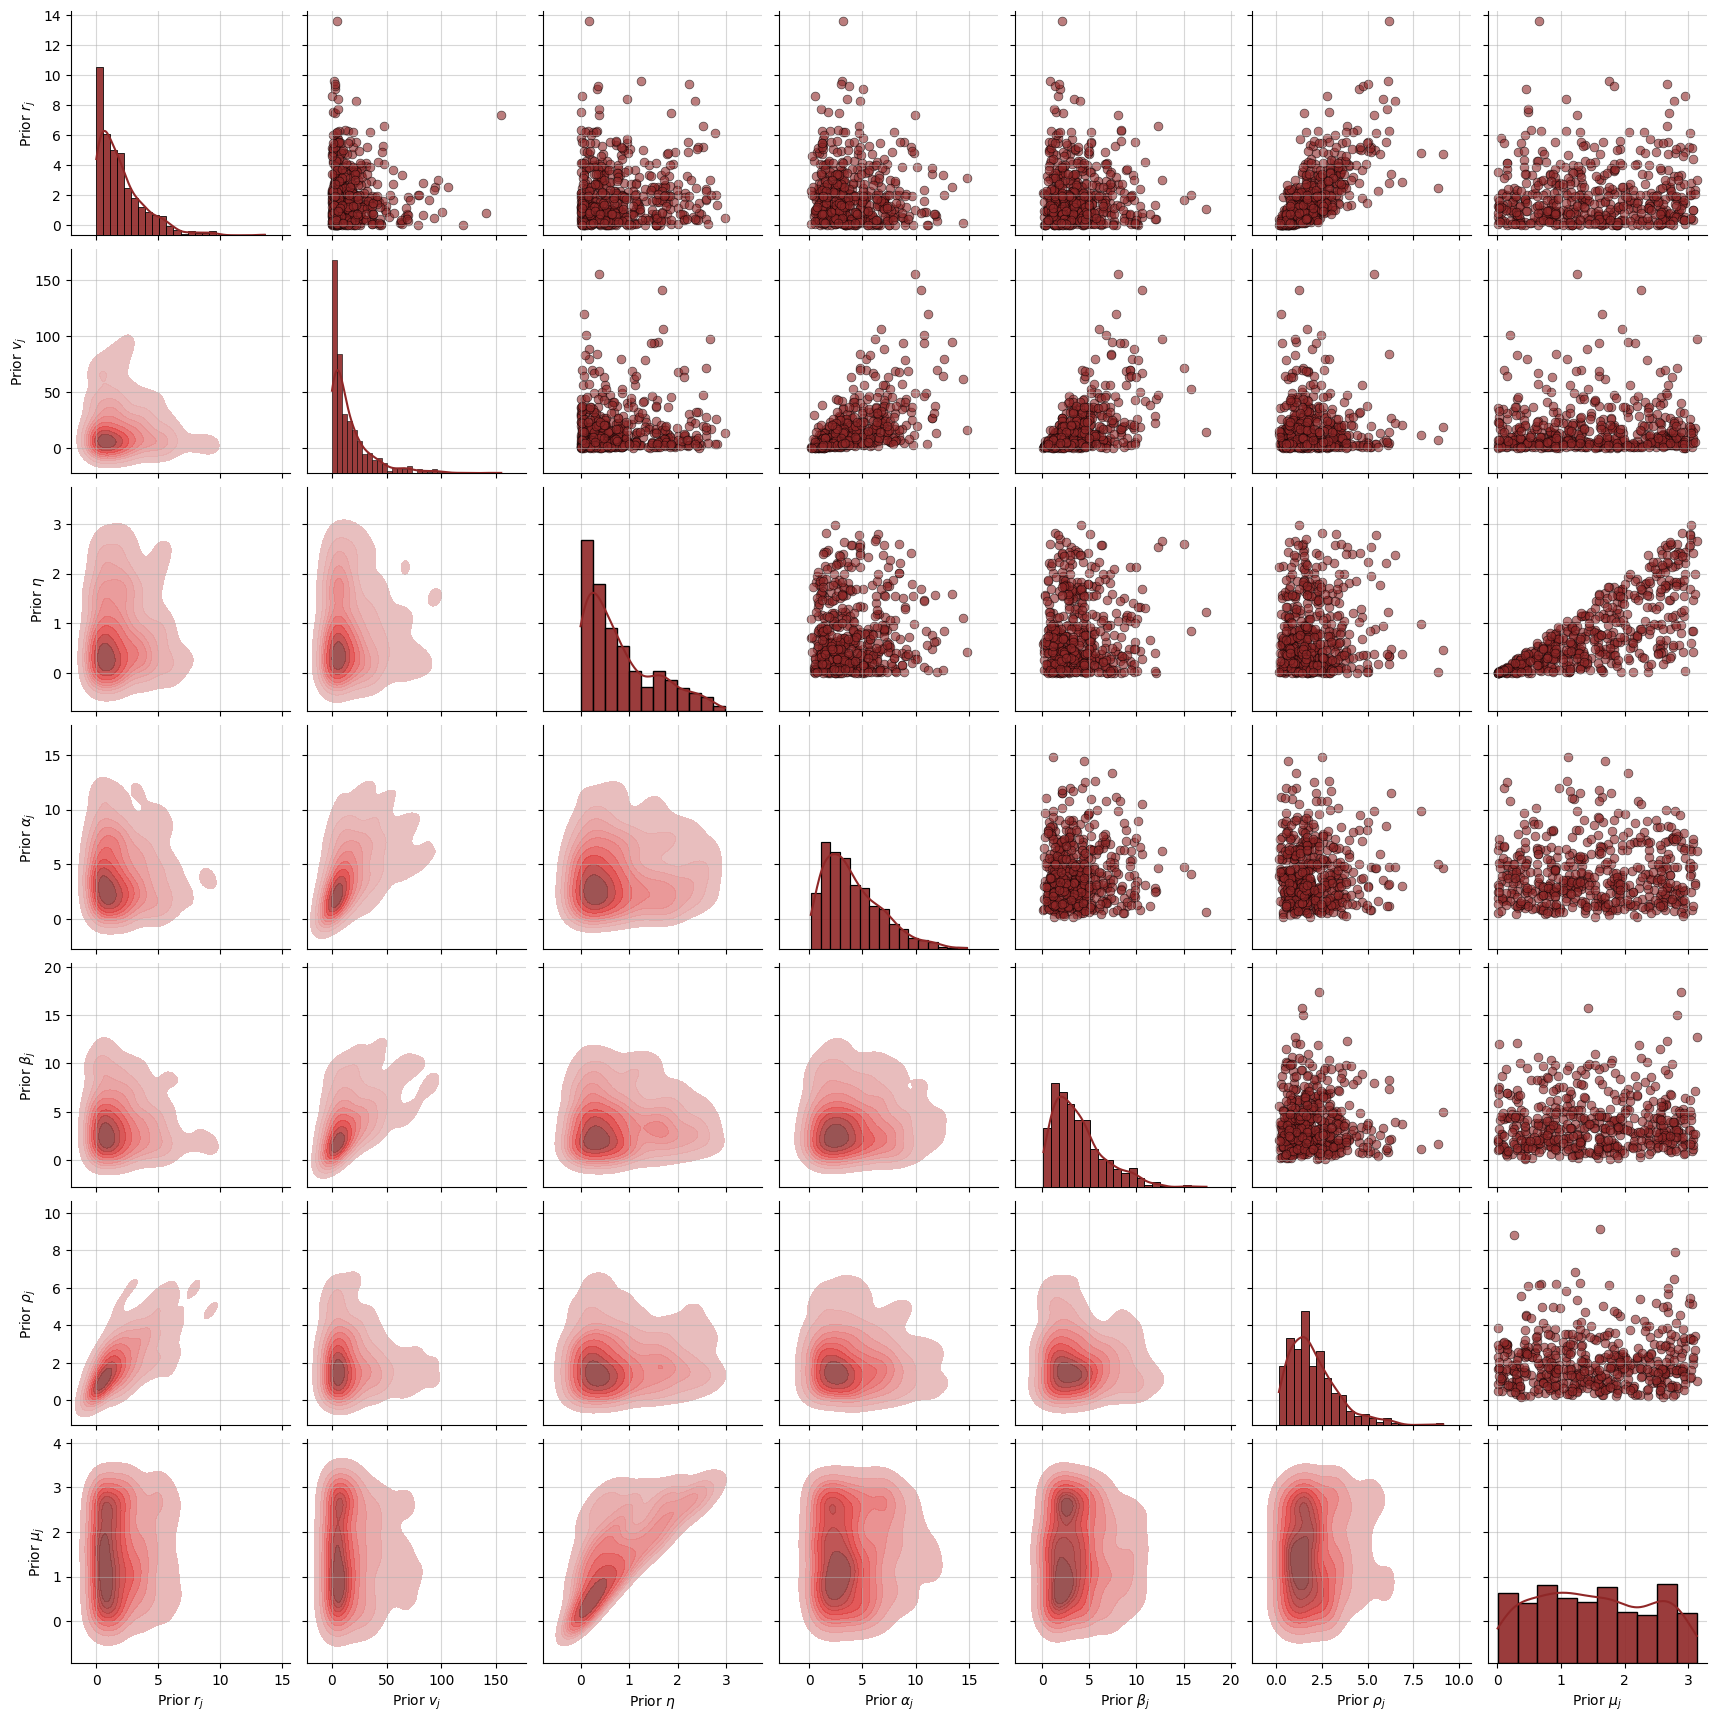

In [ ]:
f = prior.plot_prior2d(n_samples=500)

In [92]:
simulator = bf.simulation.Simulator(
    simulator_fun=partial(simulator_fun, num_timesteps=200, num_agents=6)
)

In [95]:
model = bf.simulation.GenerativeModel(
    prior=prior, simulator=simulator, simulator_is_batched=False,
    name="Vicsek"
)

INFO:root:Performing 2 pilot runs with the Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 201, 6, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Making sure that the model works.

In [96]:
test_sim = model(5)
test_sim['sim_data'].shape

(5, 201, 6, 3)

### Data Configuration and Time-Embedding

In [98]:
def configurator(input_dict: dict = None, time_embedding: bool = False):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data'].astype(np.float32)
    
    # Standardizing the data
    x_mean = np.mean(x)
    x_std = np.std(x)
    
    x = (x - x_mean) / x_std
    
    # Standardizing the prior draws
    params = input_dict['prior_draws'].astype(np.float32)
    params_mean = np.mean(params)
    params_std = np.std(params)
    
    params = (params - params_mean) / params_std

    # add time encoding to the data x
    if time_embedding:
        batch_size, num_timesteps, num_agents, _ = x.shape
        time_encoding = np.linspace(0, 1, num_timesteps)
        time_encoding_batched = np.tile(
            time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
            (batch_size, 1, num_agents, 1)
        )
        
    x1 = np.swapaxes(x, 2, 1)
    

    output_dict['summary_conditions'] = x1
    output_dict['parameters'] = params
    
    return output_dict

In [99]:
out = configurator(test_sim)
out['summary_conditions'].shape

(5, 6, 201, 3)

In [100]:
x = out['summary_conditions']
x.shape

(5, 6, 201, 3)

### Neural Approximator

Currently, it has to be assumed that all data within the timeseries for each agent are considered i.i.d., and therefore, `DeepSet` is used instead of `TimeSeriesTransformer`. It does seem that `TimeSeriesTransformer` is not compatible with `HierarchicalNetwork`. This is something that I will develop into BayesFlow in the future, once I get to know more about how things work between each other.

In [102]:
# This is incorrect, because it assumes i.i.d for timeseries. But I have to use it for now.
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(input_dim=128, summary_dim=64)
])

In [103]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [104]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net=inference_net, summary_net=summary_net)

## Training

In [105]:
trainer = bf.trainers.Trainer(
    generative_model=model,
    amortizer=amortizer,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...


ConfigurationError: Could not carry out computations of generative_model ->configurator -> amortizer -> loss! Error trace:
 Exception encountered when calling layer 'act_norm' (type ActNorm).

{{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [3] vs. [2,3,6] [Op:Mul] name: 

Call arguments received by layer 'act_norm' (type ActNorm):
  • target=tf.Tensor(shape=(2, 3, 6), dtype=float32)
  • inverse=False

In [60]:
amortizer.summary()

Model: "amortized_posterior_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  617724    
 ibleNetwork)                                                    
                                                                 
 hierarchical_network_2 (Hi  multiple                  138176    
 erarchicalNetwork)                                              
                                                                 
Total params: 755900 (2.88 MB)
Trainable params: 755816 (2.88 MB)
Non-trainable params: 84 (336.00 Byte)
_________________________________________________________________


In [61]:
simulation = model(5000)

In [62]:
losses = trainer.train_offline(simulation, epochs=100, batch_size=64, validation_sims=model(200))

Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 16.265


Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 14.690


Training epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 14.273


Training epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 13.856


Training epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 13.648


Training epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 13.383


Training epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 13.488


Training epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 13.288


Training epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 13.520


Training epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 13.169


Training epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 13.148


Training epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 13.223


Training epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 13.203


Training epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 13.088


Training epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 13.035


Training epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 12.939


Training epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 13.163


Training epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 12.920


Training epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 12.892


Training epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 13.306


Training epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 12.819


Training epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 12.854


Training epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 12.809


Training epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 12.817


Training epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 12.838


Training epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 12.718


Training epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 12.749


Training epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 12.571


Training epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 12.627


Training epoch 30:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 12.558


Training epoch 31:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 12.727


Training epoch 32:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 12.759


Training epoch 33:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 12.753


Training epoch 34:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 12.601


Training epoch 35:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 12.658


Training epoch 36:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 12.669


Training epoch 37:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 12.680


Training epoch 38:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 12.658


Training epoch 39:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 12.627


Training epoch 40:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 12.648


Training epoch 41:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 12.668


Training epoch 42:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 12.676


Training epoch 43:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 12.655


Training epoch 44:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 12.708


Training epoch 45:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 12.646


Training epoch 46:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 12.683


Training epoch 47:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 12.682


Training epoch 48:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 12.683


Training epoch 49:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 12.685


Training epoch 50:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 12.686


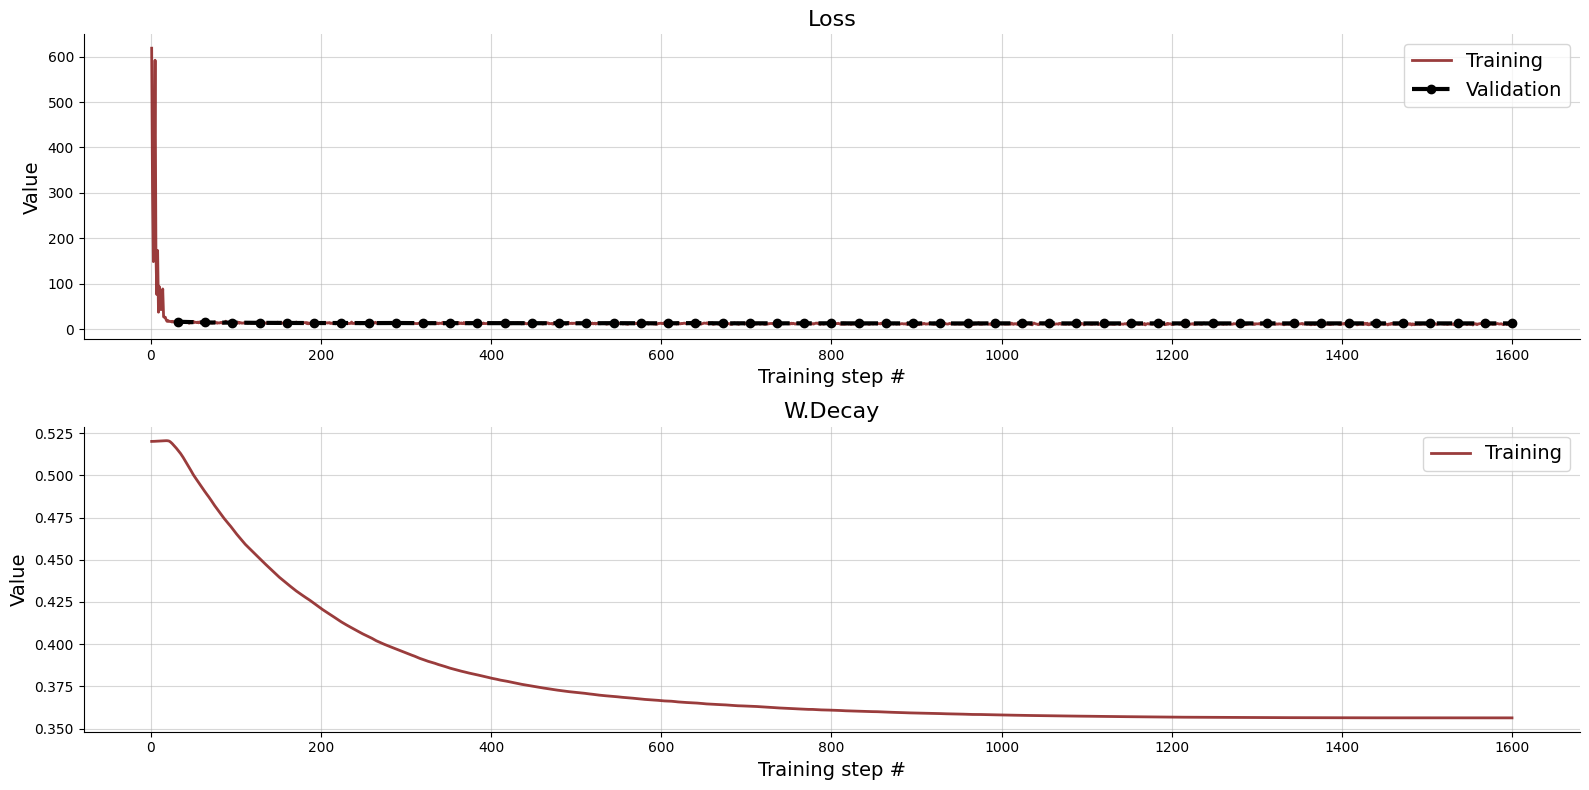

In [65]:
f = bf.diagnostics.plot_losses(losses['train_losses'], losses['val_losses'])

## Validation

In [66]:
validation_sim = model(200)

In [67]:
validation_sim = configurator(validation_sim)

In [68]:
post_samples = amortizer.sample(validation_sim, n_samples=1000)
post_samples.shape

(200, 1000, 7)

In [80]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_stds

array([[ 2.01341172, 20.74729084,  0.69772766,  2.82621391,  2.88135169,
         1.40012037,  0.90709782]])

In [81]:
prior_samples = validation_sim["parameters"] * prior_stds + prior_means

Parameter Recovery

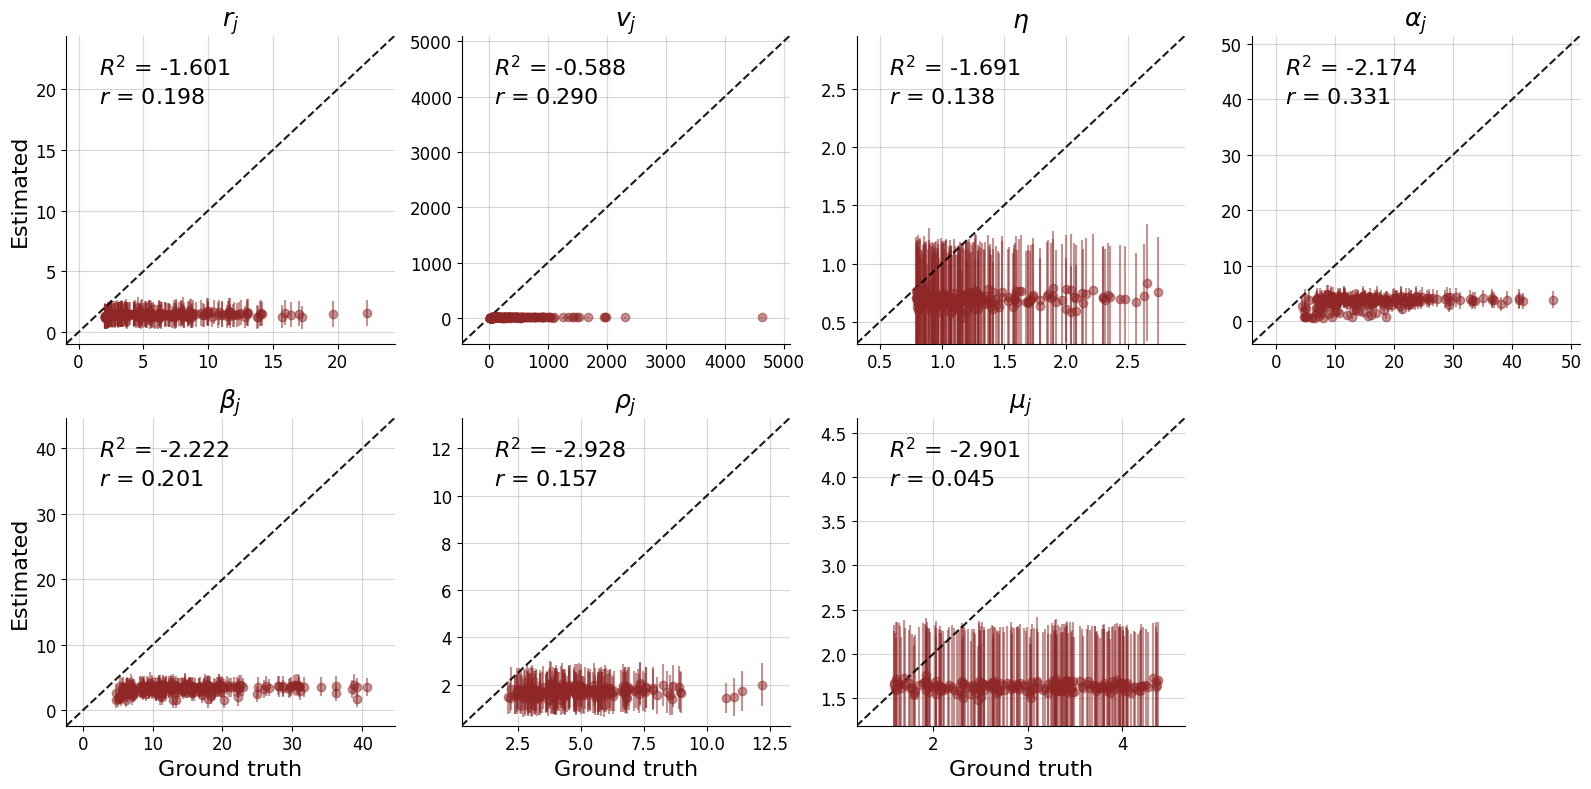

In [82]:
f = bf.diagnostics.plot_recovery(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

Possible reason: not using `TimeSeriesTransformer`.

Simulation-based calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


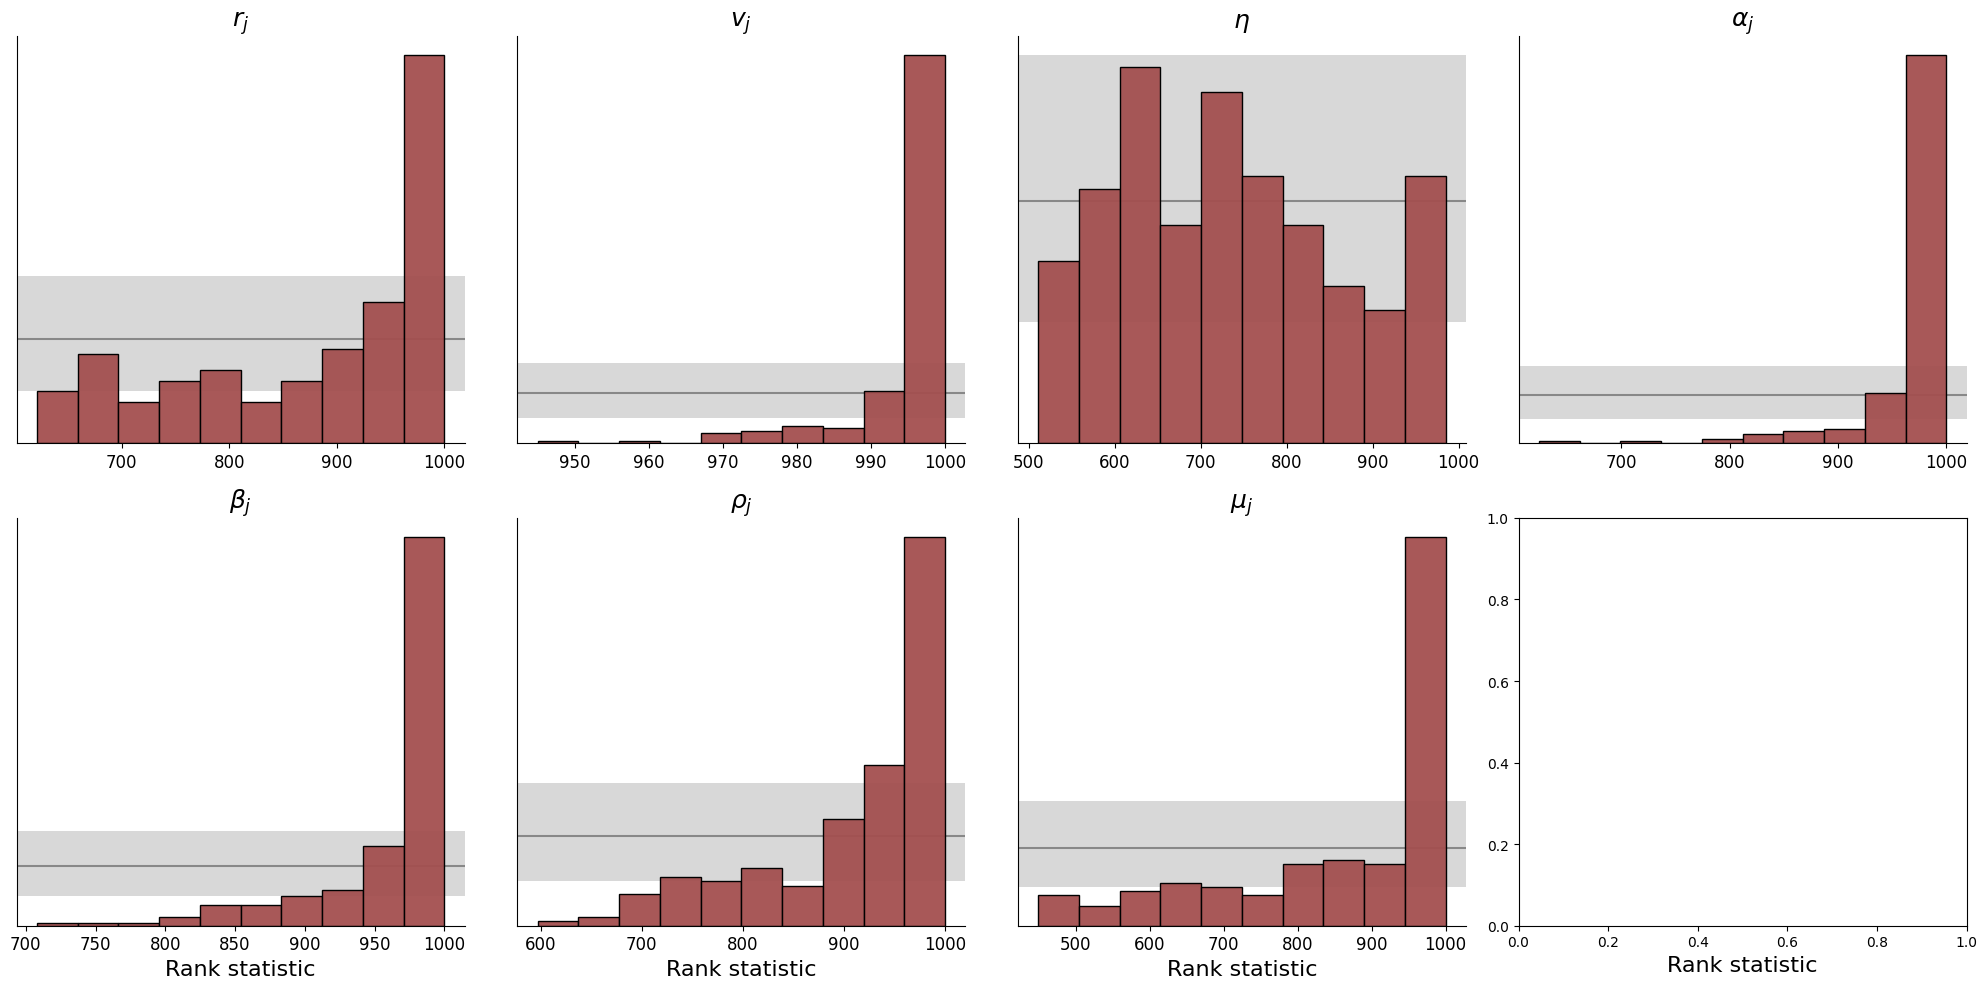

In [72]:
f = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES, num_bins=10)

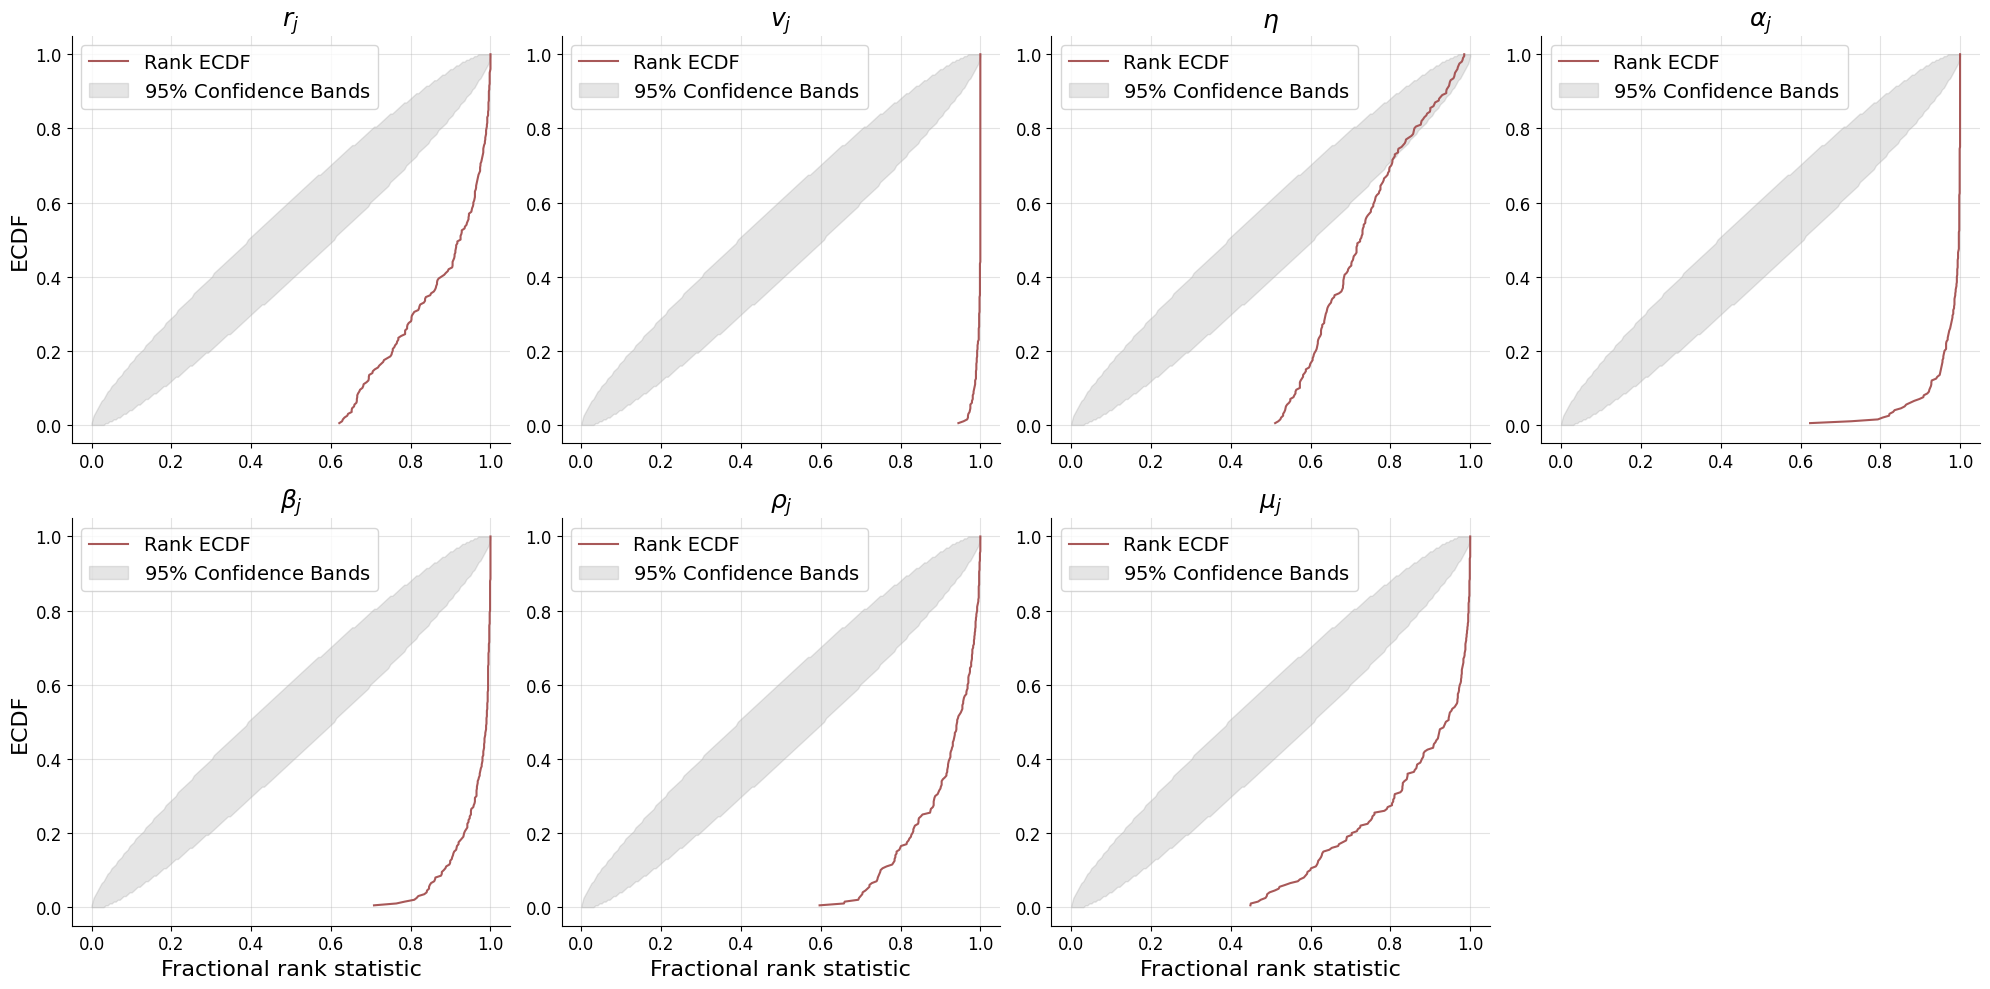

In [73]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

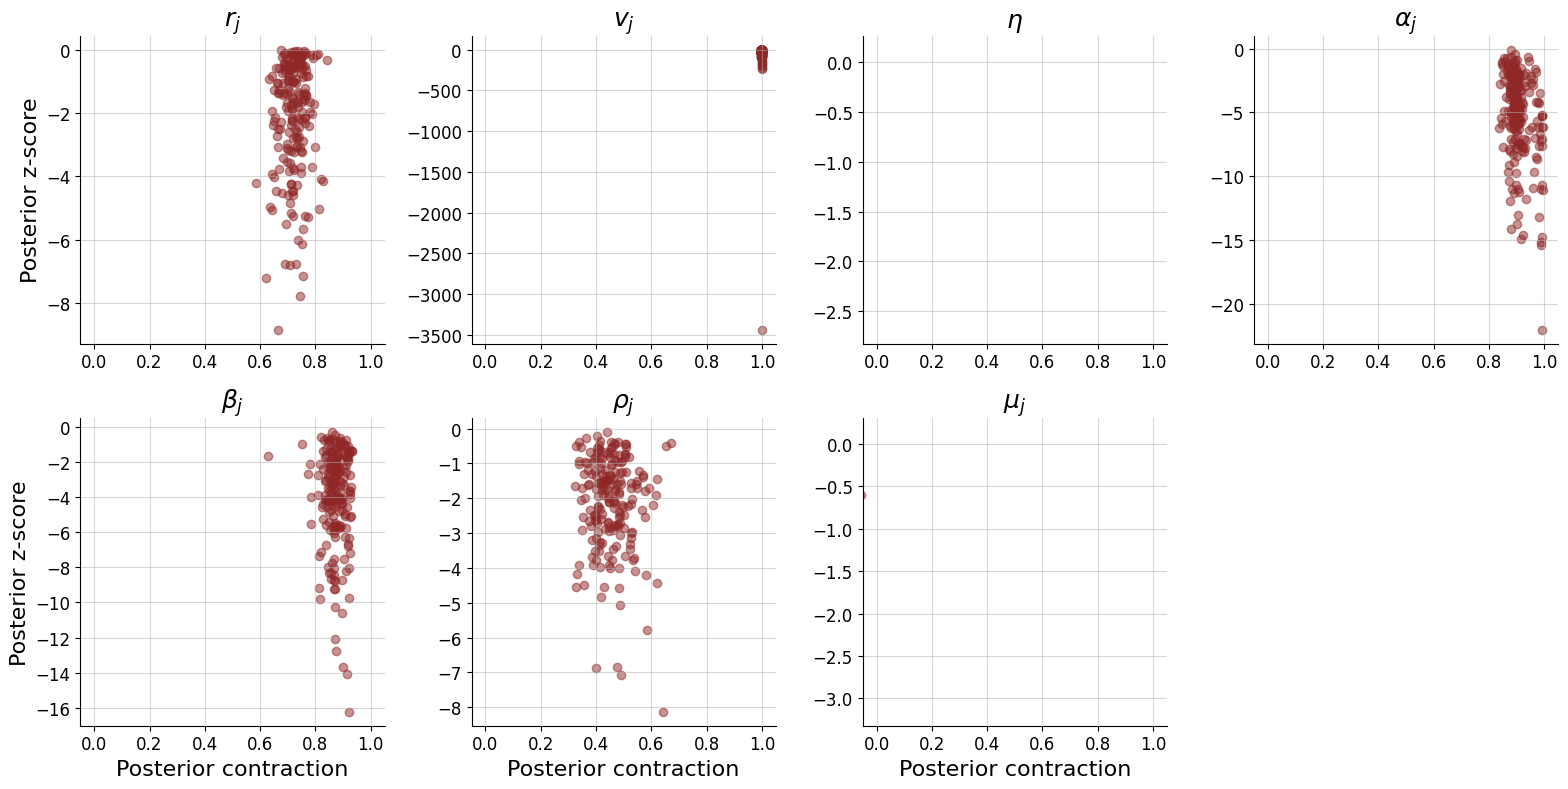

In [74]:
f = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

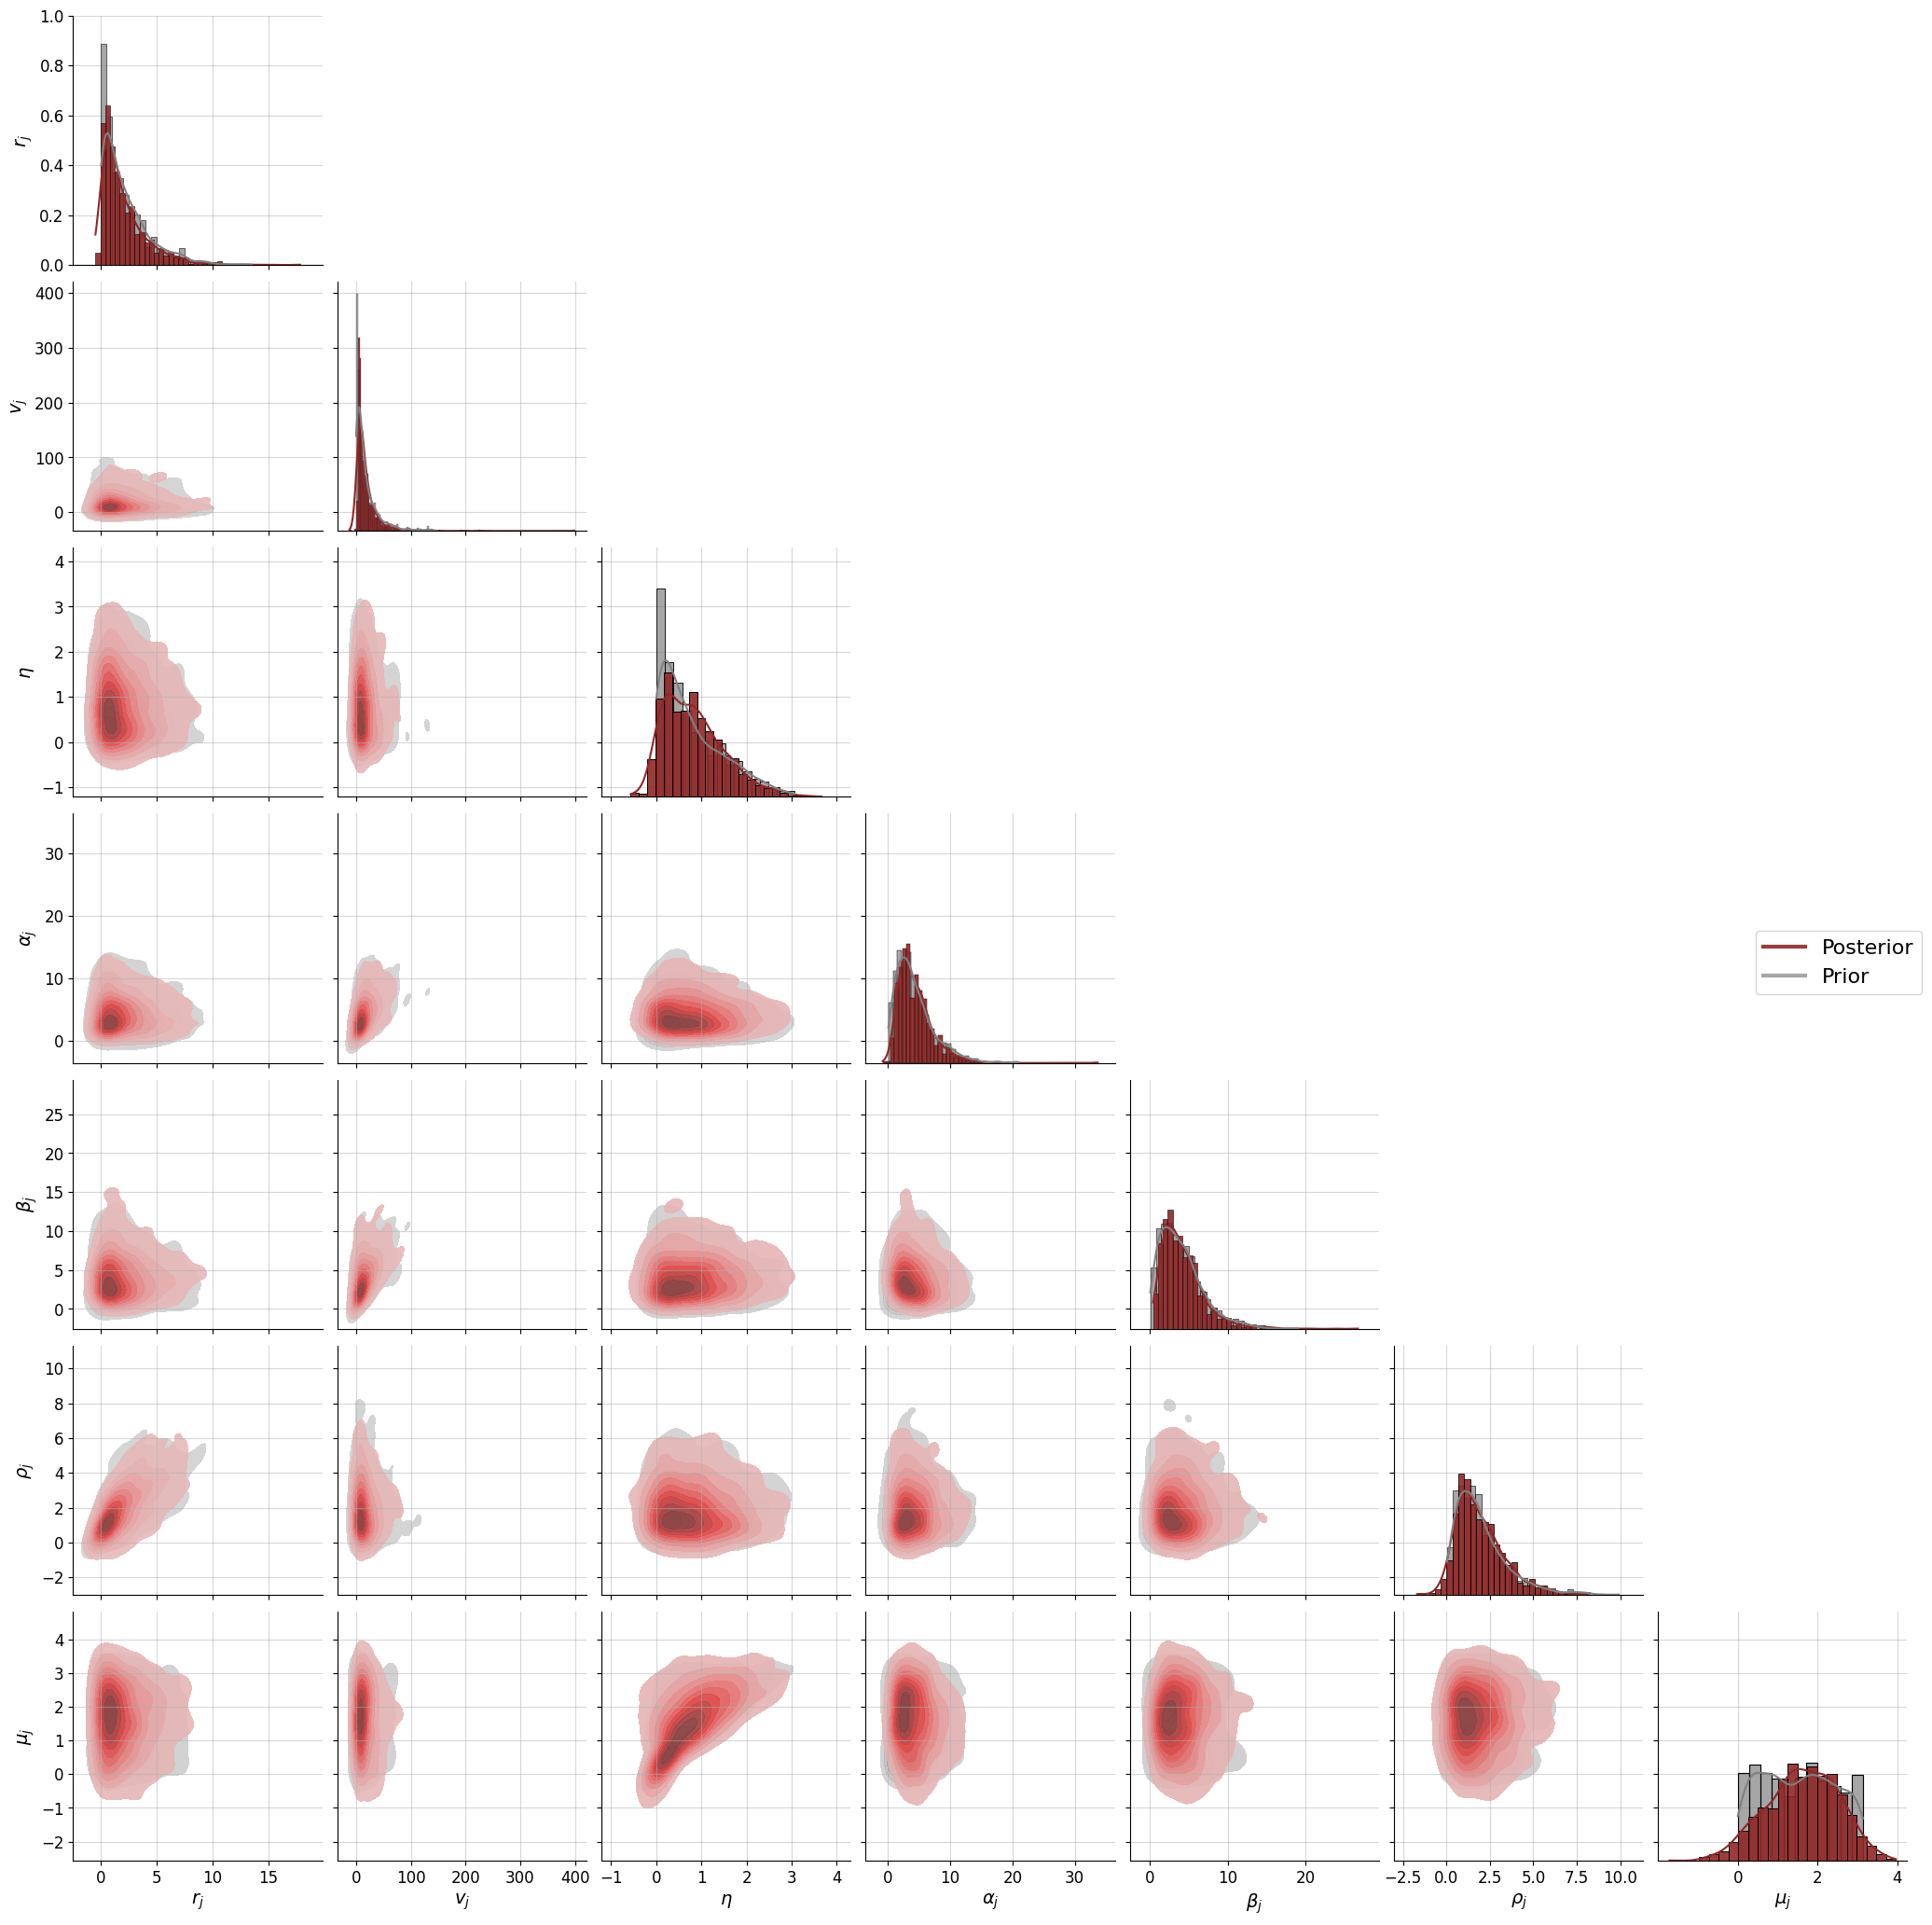

In [75]:
f = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[0], prior=prior, param_names=PARAM_NAMES)